In [1]:
from google.colab import files
uploaded = files.upload()


Saving amazon_reviews.csv to amazon_reviews.csv


In [2]:
import pandas as pd
# Load dataset
df = pd.read_csv("amazon_reviews.csv")

# Quick overview
print("Dataset loaded successfully.")
print("\nSample records:\n", df.head(3))
print("\nNumber of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("\nDataset columns:\n", df.columns)

Dataset loaded successfully.

Sample records:
    Unnamed: 0 reviewerName  overall  \
0           0          NaN      4.0   
1           1         0mie      5.0   
2           2          1K3      4.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0                   0   

   score_average_rating  wilson_lower_bound  
0                   0.0                 0.0  
1                   0.0                 0.0  
2                   0.0                 0.0  

Number of rows: 4915
Number of columns: 12

Datas

In [3]:
# Check missing values
print("\nChecking missing values:")
print(df.isnull().sum())

# Keep only relevant columns
df = df[['reviewText', 'overall']]

# Drop rows with missing reviewText or overall
df.dropna(subset=['reviewText', 'overall'], inplace=True)

print("\nRelevant columns selected:", df.columns.tolist())
print("Number of rows after dropping missing values:", df.shape[0])


Checking missing values:
Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

Relevant columns selected: ['reviewText', 'overall']
Number of rows after dropping missing values: 4914


In [4]:
# Function to map ratings to sentiment
def get_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

# Apply function
df['sentiment'] = df['overall'].apply(get_sentiment)

# Check distribution
print("\nSentiment counts:")
print(df['sentiment'].value_counts())
print("\nSentiment distribution (%):")
print(df['sentiment'].value_counts(normalize=True) * 100)


Sentiment counts:
sentiment
Positive    4448
Negative     324
Neutral      142
Name: count, dtype: int64

Sentiment distribution (%):
sentiment
Positive    90.516891
Negative     6.593407
Neutral      2.889703
Name: proportion, dtype: float64


In [5]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers/punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]# remove stopwords
    return " ".join(words)

# Apply cleaning
df['cleaned_review'] = df['reviewText'].apply(clean_text)

# Remove empty reviews after cleaning
df = df[df['cleaned_review'] != ""]

print("\nSample clean reviews:\n", df[['reviewText', 'cleaned_review']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Sample clean reviews:
                                           reviewText  \
0                                         No issues.   
1  Purchased this for my device, it worked as adv...   
2  it works as expected. I should have sprung for...   
3  This think has worked out great.Had a diff. br...   
4  Bought it with Retail Packaging, arrived legit...   

                                      cleaned_review  
0                                             issues  
1  purchased device worked advertised never much ...  
2  works expected sprung higher capacity think ma...  
3  think worked greathad diff bran gb card went s...  
4  bought retail packaging arrived legit orange e...  


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1,2),  # unigrams + bigrams
    max_features=5000,
    min_df=2, # ensures terms appearing at least 2 documents are included
)

X = tfidf.fit_transform(df['cleaned_review'])
y = df['sentiment']

print("TF-IDF feature matrix shape:", X.shape)

TF-IDF feature matrix shape: (4914, 5000)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # maintain same class distribution in train/test
)

print("\nTraining samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 3439
Testing samples: 1475


In [8]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()  # use default priors from data
nb_model.fit(X_train, y_train)

MultinomialNB()

In [9]:
nb_pred = nb_model.predict(X_test)

In [10]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'  # handle imbalance
)
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [11]:
lr_pred = lr_model.predict(X_test)

In [12]:
# Support Vectore Machine
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train, y_train)


LinearSVC(class_weight='balanced')

In [13]:
svm_pred = svm_model.predict(X_test)

In [14]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Classification Reports
print("Naive Bayes Evaluation:\n", classification_report(y_test, nb_pred, zero_division=0))
print("Logistic Regression Evaluation:\n", classification_report(y_test, lr_pred, zero_division=0))
print("Linear SVM Evaluation:\n", classification_report(y_test, svm_pred, zero_division=0))

# Weighted F1 Scores
nb_f1 = f1_score(y_test, nb_pred, average='weighted', zero_division=0)
lr_f1 = f1_score(y_test, lr_pred, average='weighted', zero_division=0)
svm_f1 = f1_score(y_test, svm_pred, average='weighted', zero_division=0)

print("\nWeighted F1-scores:")
print(f"Naive Bayes: {nb_f1:.2f}")
print(f"Logistic Regression: {lr_f1:.2f}")
print(f"Linear SVM: {svm_f1:.2f}")

# Accuracy Scores
nb_acc = accuracy_score(y_test, nb_pred)
lr_acc = accuracy_score(y_test, lr_pred)
svm_acc = accuracy_score(y_test, svm_pred)

print("\nAccuracy scores:")
print(f"Naive Bayes: {nb_acc:.2f}")
print(f"Logistic Regression: {lr_acc:.2f}")
print(f"Linear SVM: {svm_acc:.2f}")

Naive Bayes Evaluation:
               precision    recall  f1-score   support

    Negative       0.33      0.01      0.02        97
     Neutral       0.00      0.00      0.00        43
    Positive       0.91      1.00      0.95      1335

    accuracy                           0.91      1475
   macro avg       0.41      0.34      0.32      1475
weighted avg       0.84      0.91      0.86      1475

Logistic Regression Evaluation:
               precision    recall  f1-score   support

    Negative       0.55      0.69      0.61        97
     Neutral       0.14      0.12      0.13        43
    Positive       0.97      0.95      0.96      1335

    accuracy                           0.91      1475
   macro avg       0.55      0.59      0.57      1475
weighted avg       0.91      0.91      0.91      1475

Linear SVM Evaluation:
               precision    recall  f1-score   support

    Negative       0.67      0.57      0.61        97
     Neutral       0.08      0.02      0.04    

In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Models and predictions
models = {
    'Naive Bayes': nb_pred,
    'Logistic Regression': lr_pred,
    'Linear SVM': svm_pred
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    # Create DataFrame for confusion matrix
    cm_df = pd.DataFrame(cm,
                         index=[f'Actual {i}' for i in range(cm.shape[0])],
                         columns=[f'Pred {i}' for i in range(cm.shape[1])])
    print(f"\n{name} Confusion Matrix:")
    print(cm_df)



Naive Bayes Confusion Matrix:
          Pred 0  Pred 1  Pred 2
Actual 0       1       0      96
Actual 1       1       0      42
Actual 2       1       0    1334

Logistic Regression Confusion Matrix:
          Pred 0  Pred 1  Pred 2
Actual 0      67      10      20
Actual 1      13       5      25
Actual 2      42      20    1273

Linear SVM Confusion Matrix:
          Pred 0  Pred 1  Pred 2
Actual 0      55       4      38
Actual 1       8       1      34
Actual 2      19       7    1309


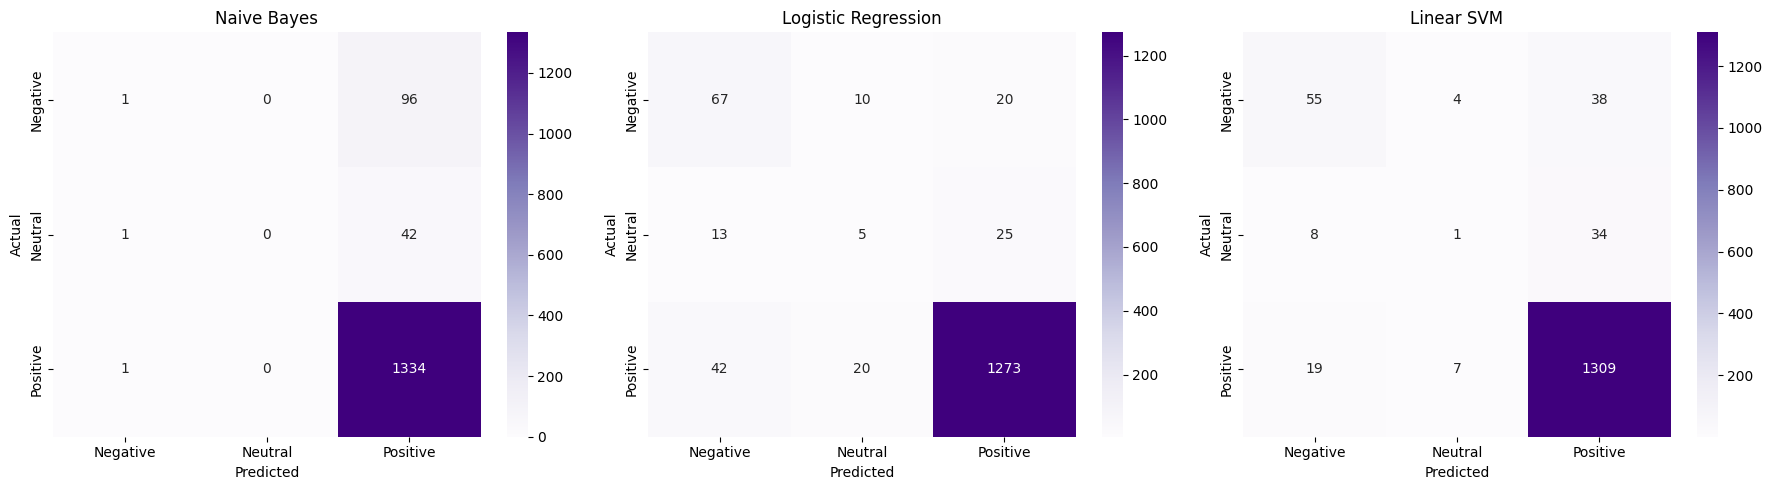

In [16]:
# Model comparison
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Naive Bayes": nb_pred,
    "Logistic Regression": lr_pred,
    "Linear SVM": svm_pred
}

labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(18, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test, preds, labels=labels)
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels,
        yticklabels=labels, cmap="Purples"
    )
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

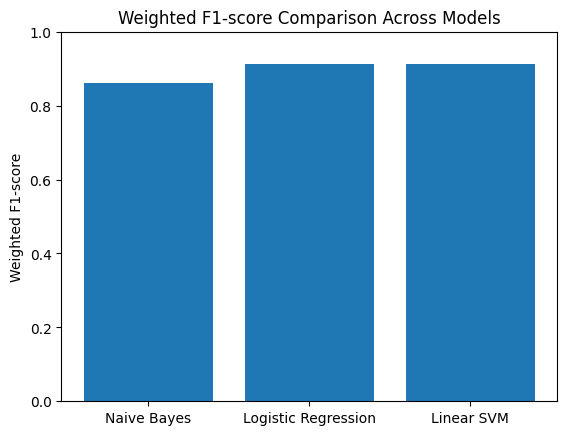

In [17]:
# Weighted F1-Score comparison
import matplotlib.pyplot as plt

models = ["Naive Bayes", "Logistic Regression", "Linear SVM"]
f1_scores = [nb_f1, lr_f1, svm_f1]

plt.figure()
plt.bar(models, f1_scores)
plt.ylim(0, 1)
plt.ylabel("Weighted F1-score")
plt.title("Weighted F1-score Comparison Across Models")
plt.show()